# Empirical Questions

In [149]:
# Libraries
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import math
import scipy.interpolate
import matplotlib.pyplot as plt

## Load data in

In [130]:
df = pd.read_csv('bond_data.csv', index_col = 0)
df['maturity_date'] = pd.to_datetime(df['maturity_date'])
df['date'] = pd.to_datetime(df['date'])
df[['bid','ask']] = df[['bid','ask']].replace('-','NaN').astype(float)
df = df.dropna()
df['close'] = (df['bid'] + df['ask'])/2

# pd.pivot_table(df, values = 'close', index = ['name', 'maturity_date', 'coupon'])
dfs = []
selected_bonds = ['CAN 1.75 Mar 23', 'CAN 0.25 Aug 23', 'CAN 2.25 Mar 24',  'CAN 1.50 Sep 24', 
                  'CAN 1.25 Mar 25', 'CAN 0.50 Sep 25', 'CAN 0.25 Mar 26', 'CAN 1.00 Sep 26', 
                  'CAN 1.25 Mar 27', 'CAN 2.75 Sep 27']

for i in range(5): #this
    dfs.append(df[(df['date'] == f'2023-01-{16+i}') & (df['name'].isin(selected_bonds)) ])
for i in range(5): 
    dfs.append(df[(df['date'] == f'2023-01-{23+i}') & (df['name'].isin(selected_bonds)) ])
dfs[0]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close
126,98.70,100.71,2023-03-01,4.30%,1.7500%,CAN 1.75 Mar 23,2023-01-16,99.705
127,96.91,98.92,2024-03-01,4.19%,2.2500%,CAN 2.25 Mar 24,2023-01-16,97.915
130,95.38,97.40,2024-09-01,3.82%,1.5000%,CAN 1.50 Sep 24,2023-01-16,96.390
136,94.20,96.22,2025-03-01,3.63%,1.2500%,CAN 1.25 Mar 25,2023-01-16,95.210
138,89.87,91.89,2026-03-01,3.36%,0.2500%,CAN 0.25 Mar 26,2023-01-16,90.880
139,92.51,92.56,2026-09-01,3.19%,1.0000%,CAN 1.00 Sep 26,2023-01-16,92.535
140,91.53,93.56,2025-09-01,3.51%,0.5000%,CAN 0.50 Sep 25,2023-01-16,92.545
143,91.98,94.01,2027-03-01,3.07%,1.2500%,CAN 1.25 Mar 27,2023-01-16,92.995
148,97.78,97.79,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-16,97.785
151,97.93,99.95,2027-09-01,2.99%,2.7500%,CAN 2.75 Sep 27,2023-01-16,98.940


We gathered bond data from https://markets.businessinsider.com/bonds/finder?borrower=71&maturity=shortterm&yield=&bondtype=2%2c3%2c4%2c16&coupon=&currency=184&rating=&country=19 for a period of 10 days. 10 of these bonds have been selected for us to work on and we store them in dfs, an array of pandas dataframes each representing one day of scraped data containing information about our 10 selected bonds

### 4.
### 4a)
(10 points) First, calculate each of your 10 selected bonds’ yield (ytm). Then provide a well labeled
plot with a 5-year yield curve (ytm curve) corresponding to each day of data superimposed
on-top of each other. You may use any interpolation technique you deem appropriate
provided you include a reasonable explanation for the technique used.

### Calculating yield to maturity (YTM) for zero coupon bonds

For a zero coupon bond, the bond will only contain a single cash flow (payment at maturity) and will be characterized by only 3 variables
- Notional (payment at maturity) N
- Price of bond P
- Time to maturity T

### $$r(T) = -\frac{log(P/N)}{T}$$

In [131]:
# adding time to maturity to our data

def ttm(maturity, date):
    delta = relativedelta(maturity, date)
    return delta.years + delta.months/12 + delta.days/365

for df in dfs:
    df['ttm'] = df.apply(lambda row: ttm(row['maturity_date'],row['date']), axis = 1)
    df.sort_values(by = ['maturity_date'], ignore_index = True, inplace = True)
dfs[0]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm
0,98.70,100.71,2023-03-01,4.30%,1.7500%,CAN 1.75 Mar 23,2023-01-16,99.705,0.118950
1,97.78,97.79,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-16,97.785,0.543836
2,96.91,98.92,2024-03-01,4.19%,2.2500%,CAN 2.25 Mar 24,2023-01-16,97.915,1.121689
3,95.38,97.40,2024-09-01,3.82%,1.5000%,CAN 1.50 Sep 24,2023-01-16,96.390,1.627169
4,94.20,96.22,2025-03-01,3.63%,1.2500%,CAN 1.25 Mar 25,2023-01-16,95.210,2.118950
5,91.53,93.56,2025-09-01,3.51%,0.5000%,CAN 0.50 Sep 25,2023-01-16,92.545,2.627169
6,89.87,91.89,2026-03-01,3.36%,0.2500%,CAN 0.25 Mar 26,2023-01-16,90.880,3.118950
7,92.51,92.56,2026-09-01,3.19%,1.0000%,CAN 1.00 Sep 26,2023-01-16,92.535,3.627169
8,91.98,94.01,2027-03-01,3.07%,1.2500%,CAN 1.25 Mar 27,2023-01-16,92.995,4.118950
9,97.93,99.95,2027-09-01,2.99%,2.7500%,CAN 2.75 Sep 27,2023-01-16,98.940,4.627169


In [132]:
# calculate ytm of all 0 coupon bonds (ttm < 0.5) located in first row of each df in dfs
for df in dfs:
    df.insert(len(df.columns), "ytm", " ")
    df.at[0, 'ytm'] = -(np.log(df.iloc[0]['close']/100)/df.iloc[0]['ttm'])
dfs[1]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm,ytm
0,98.71,100.72,2023-03-01,4.27%,1.7500%,CAN 1.75 Mar 23,2023-01-17,99.715,0.116210,0.02456
1,97.77,97.78,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-17,97.775,0.541096,
2,96.92,98.93,2024-03-01,4.18%,2.2500%,CAN 2.25 Mar 24,2023-01-17,97.925,1.118950,
3,95.48,97.49,2024-09-01,3.77%,1.5000%,CAN 1.50 Sep 24,2023-01-17,96.485,1.624429,
4,94.38,96.41,2025-03-01,3.55%,1.2500%,CAN 1.25 Mar 25,2023-01-17,95.395,2.116210,
5,91.75,93.77,2025-09-01,3.44%,0.5000%,CAN 0.50 Sep 25,2023-01-17,92.760,2.624429,
6,90.10,92.11,2026-03-01,3.31%,0.2500%,CAN 0.25 Mar 26,2023-01-17,91.105,3.116210,
7,92.71,92.76,2026-09-01,3.16%,1.0000%,CAN 1.00 Sep 26,2023-01-17,92.735,3.624429,
8,92.15,94.19,2027-03-01,3.05%,1.2500%,CAN 1.25 Mar 27,2023-01-17,93.170,4.116210,
9,98.10,100.12,2027-09-01,2.96%,2.7500%,CAN 2.75 Sep 27,2023-01-17,99.110,4.624429,


### Bootstrapping to calculate YTM of all other bonds
Once we have calculated the YTM of zero coupon bonds, we can calculate the bonds maturing between six months and one year with the following equations. For maturities between six months and one year, bonds have a coupon payment within six months and a final payment between six months and one year:
### $$P = p_1e^{-r(t_1)*t_1} + p_2e^{-r(t_2)*t_2}$$
Where $0<t_1<\frac{1}{2}<t_2<1$
- $P$ = price taken from market (dirty price)
- $p_1$ = coupon payment 6 months before maturity
- $t_1$ = 6 months before time to maturity
- $t_2$ = time to maturity
- $p_2$ = notional or face value (payment at maturity) ($100 in this case)  
  
This is essentially just a discount of all the cashflows of the bond
### $$r(t_2) = \frac{lg(p_2)-lg(P-p_1 e^{-r(t_1)*t_1})}{t_2}$$

based on the general formula
### $$P = \sum_i p_i e^{-r(t_i)t_i}$$
### $$r(t_n) = \frac{lg(p_n)-lg(P - \sum_{i=1}^{n-1} p_i e^{-r(t_i)*t_i})}{t_n}$$
We can thus continue this process step by step for each time step of 6 months (1 coupon payment)

In [177]:
# calculate ytms for all other bonds

for df in dfs:
    for i in range(1,10):
        pi = float(df.iloc[i]['coupon'][:-2])/2 # divide by 2 because this coupon is paid twice a year
        pn = 100
        tn = df.iloc[i]['ttm']
        P = df.iloc[i]['close']
        
        sumTerm = 0
        for j in range(1,i):
            tj = (tn + 0.5 * (i - (j-1)) )  
            r_tj = df.iloc[j]['ytm']
            sumTerm += pi*math.exp(-r_tj * tj)
        
        df.at[i, 'ytm'] = ( (np.log(p2) - np.log(P - sumTerm))
                           /t2 )
        
for df in dfs:
    df['ytm'] = df['ytm']*100
dfs[1]

,bid,ask,maturity_date,bond_yield,coupon,name,date,close,ttm,ytm
0,98.71,100.72,2023-03-01,4.27%,1.7500%,CAN 1.75 Mar 23,2023-01-17,99.715,0.116210,2.455957
1,97.77,97.78,2023-08-01,4.49%,0.2500%,CAN 0.25 Aug 23,2023-01-17,97.775,0.541096,0.489474
2,96.92,98.93,2024-03-01,4.18%,2.2500%,CAN 2.25 Mar 24,2023-01-17,97.925,1.118950,0.704874
3,95.48,97.49,2024-09-01,3.77%,1.5000%,CAN 1.50 Sep 24,2023-01-17,96.485,1.624429,1.113472
4,94.38,96.41,2025-03-01,3.55%,1.2500%,CAN 1.25 Mar 25,2023-01-17,95.395,2.116210,1.445837
5,91.75,93.77,2025-09-01,3.44%,0.5000%,CAN 0.50 Sep 25,2023-01-17,92.760,2.624429,1.861583
6,90.10,92.11,2026-03-01,3.31%,0.2500%,CAN 0.25 Mar 26,2023-01-17,91.105,3.116210,2.168344
7,92.71,92.76,2026-09-01,3.16%,1.0000%,CAN 1.00 Sep 26,2023-01-17,92.735,3.624429,2.306394
8,92.15,94.19,2027-03-01,3.05%,1.2500%,CAN 1.25 Mar 27,2023-01-17,93.170,4.116210,2.494658
9,98.10,100.12,2027-09-01,2.96%,2.7500%,CAN 2.75 Sep 27,2023-01-17,99.110,4.624429,2.478958


### Interpolation
Now that we have calculated the yield to maturity of our 10 selected bonds spaced approximately 6 months apart, we can interpolate the yields for every other month in our yield curve  
  
To handle this task, we will use the scipy.interpolate.CubicSpline method. This will allow us to interpolate the data with a piecewise cubic polynomial

In [184]:
ytms = []
ttms = []

for df in dfs:
    ytms.append(df['ytm'])
    ttms.append(df['ttm'])

X = np.linspace(0,5,20)
interpolated_ytms = []
for ytm,ttm in zip(ytms,ttms):
    cs = scipy.interpolate.CubicSpline(x = ttm, y = ytm, bc_type = 'not-a-knot')
    output_data = cs(X)
    interpolated_ytms.append(output_data)
interpolated_ytms[0]

array([3.64184969, 1.47102464, 0.51751763, 0.37212469, 0.62564187,
       0.90015893, 1.10172349, 1.28413977, 1.47801319, 1.69599915,
       1.91597341, 2.1061721 , 2.23681598, 2.3044172 , 2.37205241,
       2.47389845, 2.55992293, 2.56929966, 2.4412025 , 2.11480526])

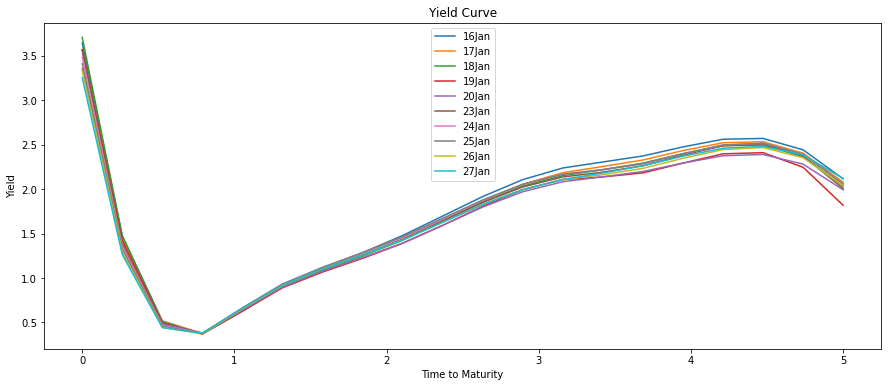

In [185]:
dates = ["16Jan", "17Jan", "18Jan", "19Jan", "20Jan", "23Jan", "24Jan", "25Jan", "26Jan", "27Jan"]
plt.figure(figsize=(15,6))

for ytm,date in zip(interpolated_ytms, dates):
    plt.plot(X, ytm, label= date)

plt.xlabel('Time to Maturity')
plt.ylabel('Yield')
plt.title('Yield Curve')
plt.legend()
plt.show()